<a href="https://colab.research.google.com/github/OleksiiLatypov/Practical_Deep_Learning_with_PyTorch/blob/main/week3/pneumonia_resnet_15_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'rsna-pneumonia-detection-challenge:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F10338%2F862042%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240519%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240519T183328Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D797466b669074cea354eba586a9e97b871e9395a6a532e8bb57909b2e531a46f067a1f9dca6e21b174c12cd0f6ee28f58cf02518384e249e1d65dc460378351362cc6be5429404a3f1829a5e4c7581c07a21a05251004d360e5fe18f3da741126efc721514c922369f645e5b92c80ddf3e5584ef62693cae385cbe312d076dc59bace83b7eee13d954468e0bcaa63781910e108fa071a86212e13366413deccd0d55ddb25c9508daf4407c5d384233c058dcd1ccf7cfb2f7dcc685e8471bd48676c63aac2efe80ca39d1ffdc82eedfdb900579f1ef60ad757228fe0f62ab381d3fac4d68f944f06479b3d965752f41b967ea66e7bf3b585559d8e4dd016c7dcd'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pydicom
import os
import pandas as pd
import numpy as np

import cv2
import matplotlib.pyplot as plt

In [ ]:
class_data = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')
class_data.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [ ]:
train_labels = pd.read_csv("/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv")
train_labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


**Define the directory where the DICOM images are stored**

In [ ]:
data_dir = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images'

In [ ]:
num_images = os.listdir(data_dir)
print(len(num_images))

26684


**Combine metadata from class_data and train_labels by joining them on every column except ‘patientId’**

In [ ]:
dataset = pd.concat([class_data.drop(columns = 'patientId'), train_labels], axis = 1)

In [ ]:
dataset.head()

,class,patientId,x,y,width,height,Target,bbox,vals
0,No Lung Opacity / Not Normal,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,"[nan, nan, nan, nan]","nan, nan, nan, nan"
1,No Lung Opacity / Not Normal,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,"[nan, nan, nan, nan]","nan, nan, nan, nan"
2,No Lung Opacity / Not Normal,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,"[nan, nan, nan, nan]","nan, nan, nan, nan"
3,Normal,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,"[nan, nan, nan, nan]","nan, nan, nan, nan"
4,Lung Opacity,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,"[264.0, 152.0, 213.0, 379.0]","264.0, 152.0, 213.0, 379.0"


In [ ]:
dataset['bbox'] = dataset[['x', 'y', 'width', 'height']].values.tolist()
dataset.head()

,class,patientId,x,y,width,height,Target,bbox,vals
0,No Lung Opacity / Not Normal,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,"[nan, nan, nan, nan]","nan, nan, nan, nan"
1,No Lung Opacity / Not Normal,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,"[nan, nan, nan, nan]","nan, nan, nan, nan"
2,No Lung Opacity / Not Normal,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,"[nan, nan, nan, nan]","nan, nan, nan, nan"
3,Normal,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,"[nan, nan, nan, nan]","nan, nan, nan, nan"
4,Lung Opacity,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,"[264.0, 152.0, 213.0, 379.0]","264.0, 152.0, 213.0, 379.0"


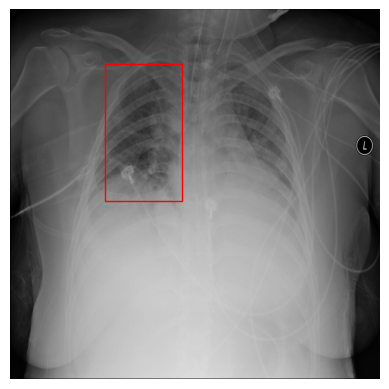

In [ ]:
from matplotlib.patches import Rectangle

dicom_file_path = "/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm"
ds = pydicom.dcmread(dicom_file_path)

# Extract image data and metadata
image_data = ds.pixel_array
x, y, width, height = 264, 152, 213, 379  # Example coordinates (replace with your own)

# Display DICOM image
plt.imshow(image_data, cmap='gray')

# Add a rectangle to highlight the region of interest
rect = Rectangle((x, y), width, height, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)

plt.axis('off')  # Turn off axes
plt.show()

In [ ]:
pneumonia = dataset[dataset['Target'] == 1]
pneumonia.head(10)

,class,patientId,x,y,width,height,Target,bbox,vals
4,Lung Opacity,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,"[264.0, 152.0, 213.0, 379.0]","264.0, 152.0, 213.0, 379.0"
5,Lung Opacity,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,"[562.0, 152.0, 256.0, 453.0]","562.0, 152.0, 256.0, 453.0"
8,Lung Opacity,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,"[323.0, 577.0, 160.0, 104.0]","323.0, 577.0, 160.0, 104.0"
9,Lung Opacity,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,"[695.0, 575.0, 162.0, 137.0]","695.0, 575.0, 162.0, 137.0"
14,Lung Opacity,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1,"[288.0, 322.0, 94.0, 135.0]","288.0, 322.0, 94.0, 135.0"
15,Lung Opacity,00aecb01-a116-45a2-956c-08d2fa55433f,547.0,299.0,119.0,165.0,1,"[547.0, 299.0, 119.0, 165.0]","547.0, 299.0, 119.0, 165.0"
16,Lung Opacity,00c0b293-48e7-4e16-ac76-9269ba535a62,306.0,544.0,168.0,244.0,1,"[306.0, 544.0, 168.0, 244.0]","306.0, 544.0, 168.0, 244.0"
17,Lung Opacity,00c0b293-48e7-4e16-ac76-9269ba535a62,650.0,511.0,206.0,284.0,1,"[650.0, 511.0, 206.0, 284.0]","650.0, 511.0, 206.0, 284.0"
19,Lung Opacity,00f08de1-517e-4652-a04f-d1dc9ee48593,181.0,184.0,206.0,506.0,1,"[181.0, 184.0, 206.0, 506.0]","181.0, 184.0, 206.0, 506.0"
20,Lung Opacity,00f08de1-517e-4652-a04f-d1dc9ee48593,571.0,275.0,230.0,476.0,1,"[571.0, 275.0, 230.0, 476.0]","571.0, 275.0, 230.0, 476.0"


In [ ]:
to_display = pneumonia.head(10)
to_display

,class,patientId,x,y,width,height,Target,bbox
4,Lung Opacity,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,"[264.0, 152.0, 213.0, 379.0]"
5,Lung Opacity,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,"[562.0, 152.0, 256.0, 453.0]"
8,Lung Opacity,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,"[323.0, 577.0, 160.0, 104.0]"
9,Lung Opacity,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,"[695.0, 575.0, 162.0, 137.0]"
14,Lung Opacity,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1,"[288.0, 322.0, 94.0, 135.0]"
15,Lung Opacity,00aecb01-a116-45a2-956c-08d2fa55433f,547.0,299.0,119.0,165.0,1,"[547.0, 299.0, 119.0, 165.0]"
16,Lung Opacity,00c0b293-48e7-4e16-ac76-9269ba535a62,306.0,544.0,168.0,244.0,1,"[306.0, 544.0, 168.0, 244.0]"
17,Lung Opacity,00c0b293-48e7-4e16-ac76-9269ba535a62,650.0,511.0,206.0,284.0,1,"[650.0, 511.0, 206.0, 284.0]"
19,Lung Opacity,00f08de1-517e-4652-a04f-d1dc9ee48593,181.0,184.0,206.0,506.0,1,"[181.0, 184.0, 206.0, 506.0]"
20,Lung Opacity,00f08de1-517e-4652-a04f-d1dc9ee48593,571.0,275.0,230.0,476.0,1,"[571.0, 275.0, 230.0, 476.0]"


00436515-870c-4b36-a041-de91049b9ab4
X: 264.0, Y: 152.0, WIDTH: 213.0, HEIGHT: 379.0
X: 562.0, Y: 152.0, WIDTH: 256.0, HEIGHT: 453.0


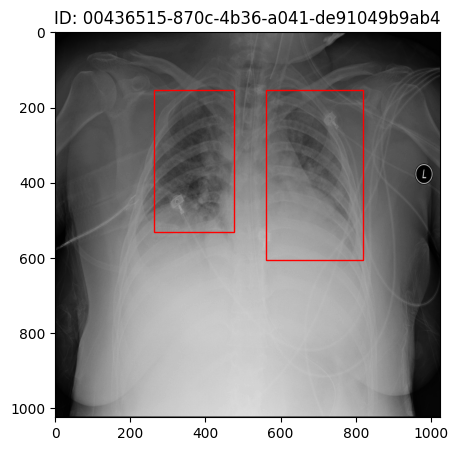

00704310-78a8-4b38-8475-49f4573b2dbb
X: 323.0, Y: 577.0, WIDTH: 160.0, HEIGHT: 104.0
X: 695.0, Y: 575.0, WIDTH: 162.0, HEIGHT: 137.0


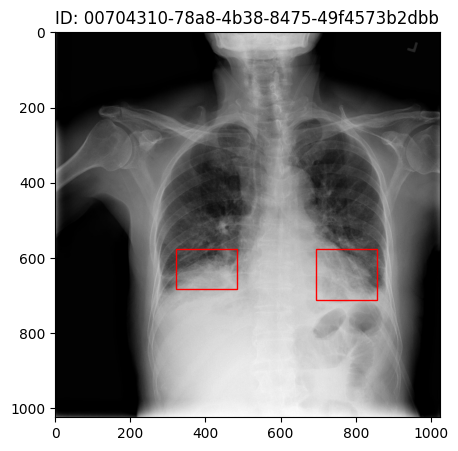

00aecb01-a116-45a2-956c-08d2fa55433f
X: 288.0, Y: 322.0, WIDTH: 94.0, HEIGHT: 135.0
X: 547.0, Y: 299.0, WIDTH: 119.0, HEIGHT: 165.0


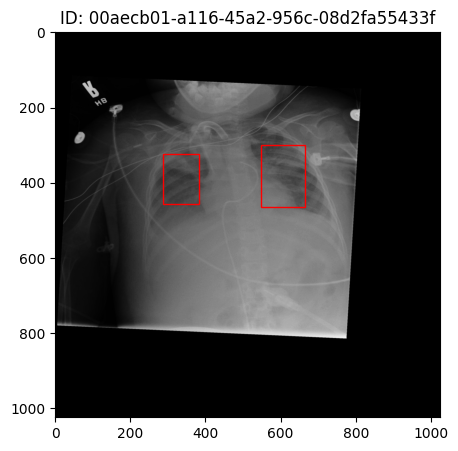

00c0b293-48e7-4e16-ac76-9269ba535a62
X: 306.0, Y: 544.0, WIDTH: 168.0, HEIGHT: 244.0
X: 650.0, Y: 511.0, WIDTH: 206.0, HEIGHT: 284.0


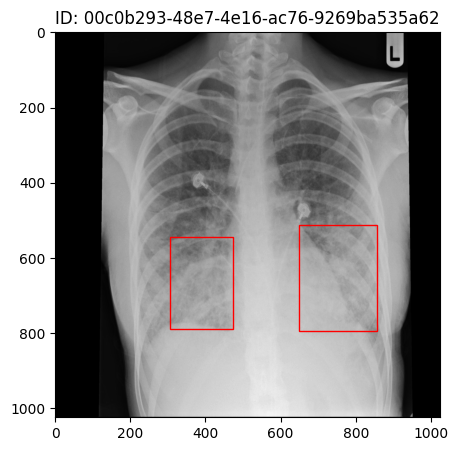

00f08de1-517e-4652-a04f-d1dc9ee48593
X: 181.0, Y: 184.0, WIDTH: 206.0, HEIGHT: 506.0
X: 571.0, Y: 275.0, WIDTH: 230.0, HEIGHT: 476.0


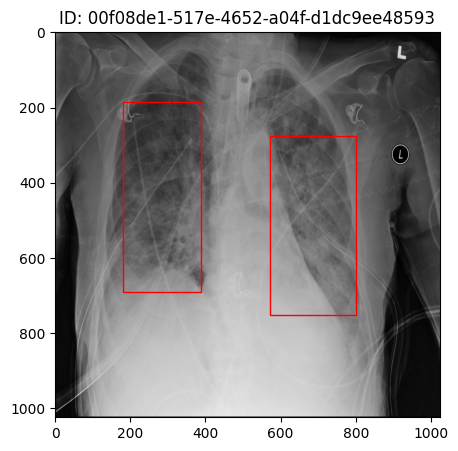

In [ ]:

import pydicom
import matplotlib.pyplot as plt


uniq_patients_ids = to_display['patientId'].unique()
uniq_patients_ids

for patient_id in uniq_patients_ids:
    plt.figure(figsize=(5, 5))
    patient_data = to_display[to_display['patientId'] == patient_id]
    #display(patient_data)

    ds = pydicom.dcmread(f'{data_dir}/{patient_id}.dcm')
    image = ds.pixel_array
    print(patient_id)
    plt.title(f'ID: {patient_id}')
    plt.imshow(image, cmap='gray')
    for i, row in patient_data.iterrows():
        x, y, width, height = row['bbox']
        print(f'X: {x}, Y: {y}, WIDTH: {width}, HEIGHT: {height}')
        plt.gca().add_patch(plt.Rectangle((x, y), width, height, edgecolor='r', facecolor='none'))
    plt.show()



In [ ]:
image_directory = '/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/'

In [ ]:
dataset['image_path'] = image_directory + dataset['patientId'] + '.dcm'
dataset.head()

,class,patientId,x,y,width,height,Target,bbox,image_path
0,No Lung Opacity / Not Normal,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,"[nan, nan, nan, nan]",/kaggle/input/rsna-pneumonia-detection-challen...
1,No Lung Opacity / Not Normal,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,"[nan, nan, nan, nan]",/kaggle/input/rsna-pneumonia-detection-challen...
2,No Lung Opacity / Not Normal,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,"[nan, nan, nan, nan]",/kaggle/input/rsna-pneumonia-detection-challen...
3,Normal,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,"[nan, nan, nan, nan]",/kaggle/input/rsna-pneumonia-detection-challen...
4,Lung Opacity,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,"[264.0, 152.0, 213.0, 379.0]",/kaggle/input/rsna-pneumonia-detection-challen...


In [ ]:
dataset['vals'] = dataset[['x', 'y', 'width', 'height']].apply(lambda x: ', '.join(str(i) for i in x), axis=1)
dataset.head()

,class,patientId,x,y,width,height,Target,bbox,vals
0,No Lung Opacity / Not Normal,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,"[nan, nan, nan, nan]","nan, nan, nan, nan"
1,No Lung Opacity / Not Normal,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,"[nan, nan, nan, nan]","nan, nan, nan, nan"
2,No Lung Opacity / Not Normal,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,"[nan, nan, nan, nan]","nan, nan, nan, nan"
3,Normal,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,"[nan, nan, nan, nan]","nan, nan, nan, nan"
4,Lung Opacity,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,"[264.0, 152.0, 213.0, 379.0]","264.0, 152.0, 213.0, 379.0"


**Function to read DICOM images, resize them to 224x224 pixels, convert to RGB, and store them along with their targets**

In [ ]:
def read_and_resize_images(pneumonia, num_samples=None):
    resized_images = []
    boxes = []
    if num_samples:
        pneumonia = pneumonia[:num_samples]

    for _, row in pneumonia.iterrows():
        image_path = row['image_path']
        target = row['Target']

        dicom_data = pydicom.dcmread(image_path)
        img = dicom_data.pixel_array
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        resized_images.append(img)
        boxes.append(np.array(target, dtype=np.float32))
    return resized_images, boxes

In [ ]:
import random
random_patient_id = random.choice(dataset['patientId'])
image_path = dataset[dataset['patientId'] == random_patient_id]['image_path'].values[0]
image


KeyError: 'image_path'

In [ ]:
dicom_data = pydicom.read_file(image_path)

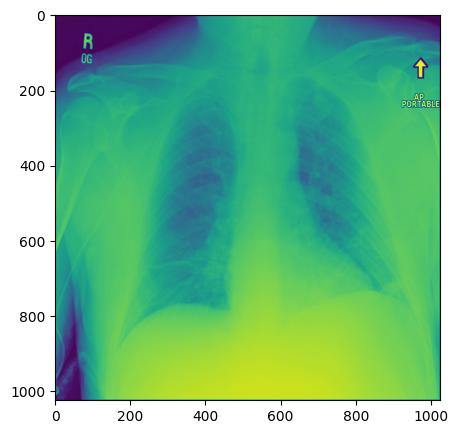

In [ ]:
def visualize_dicom_image(dicom_data):
    img = dicom_data.pixel_array
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.show()
visualize_dicom_image(dicom_data)

# **Simple CNN**

In [ ]:
from sklearn.model_selection import train_test_split
from torchvision import transforms

In [ ]:
X, y = read_and_resize_images(dataset[:1000])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train[0].shape

(224, 224, 3)

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [ ]:
import torch
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn

# PyTorch Dataset class that encapsulates the preprocessed images and corresponding labels

In [ ]:
class PneumoniaDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]
        label = torch.tensor(self.labels[index], dtype=torch.float)
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return self.images.__len__()


**Create dataset and dataloader instances for training and testing**

In [ ]:
train_dataset = PneumoniaDataset(X_train, y_train, transform=transform)
#train_dataset[0]
test_dataset = PneumoniaDataset(X_test, y_test, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=True)

**Prepare the Pretrained ResNet101 model for fine-tuning, and set up the loss function and optimizer**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet101 = models.resnet101(pretrained=True)
num_classes = 2
resnet101.fc = nn.Linear(resnet101.fc.in_features, num_classes)
resnet101 = resnet101.to(device)


criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(resnet101.parameters(), lr=0.001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 155MB/s] 


In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 3            |        cudaMalloc retries: 3         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  15905 MiB |  15905 MiB |  17960 MiB |   2054 MiB |\n|       from large pool |  15853 MiB |  15853 MiB |  17907 MiB |   2054 MiB |\n|       from small pool |     51 MiB |     52 MiB |     52 MiB |      0 MiB |\n|---------------------------------------------------------------------------|\n| Active memory         |  15905 MiB |  15905 MiB |  17960 MiB |   2054 MiB |\n|       from large pool |  15853 MiB |  15853 MiB |

**Training loop for the ResNet101 model with a set number of epochs**

In [ ]:
num_epochs = 10

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    resnet101.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = resnet101(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}%")

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 15.89 GiB of which 34.12 MiB is free. Process 2462 has 15.86 GiB memory in use. Of the allocated memory 15.54 GiB is allocated by PyTorch, and 34.92 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF